In [2]:
# Step 1: Dataset Loading
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
# Step 2: Data Augmentation and Loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of training data for validation
)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Load the new validation data
new_val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Load the old validation data
old_val_datagen = ImageDataGenerator(rescale=1./255)
old_val_generator = old_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)



Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [4]:
# Collect old validation data
old_val_images = []
old_val_labels = []

# Loop through old validation generator to collect all data
for _ in range(len(old_val_generator)):
    images, labels = next(old_val_generator)
    old_val_images.append(images)
    old_val_labels.append(labels)

# Concatenate to form complete old validation set
old_val_images = np.concatenate(old_val_images)
old_val_labels = np.concatenate(old_val_labels)

# Collect new validation data similarly
new_val_images = []
new_val_labels = []

for _ in range(len(new_val_generator)):
    images, labels = next(new_val_generator)
    new_val_images.append(images)
    new_val_labels.append(labels)

# Concatenate to form complete new validation set
new_val_images = np.concatenate(new_val_images)
new_val_labels = np.concatenate(new_val_labels)

# Combine old and new validation sets
combined_val_images = np.concatenate((old_val_images, new_val_images))
combined_val_labels = np.concatenate((old_val_labels, new_val_labels))

# Check the number of validation samples
num_val_images = combined_val_images.shape[0]
num_val_labels = combined_val_labels.shape[0]

print(f'Number of validation images: {num_val_images}')
print(f'Number of validation labels: {num_val_labels}')


Number of validation images: 1059
Number of validation labels: 1059


In [5]:
# Step 3: Model Building
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Step 4: Define Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [7]:
# Step 5: Train the Model
history = model.fit(
    train_generator,
    validation_data=(combined_val_images, combined_val_labels),  # Use the combined validation data
    epochs=25,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727441473.475463     126 service.cc:145] XLA service 0x784a2c001410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727441473.475520     126 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727441473.475524     126 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727441520.563433     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.8909 - loss: 0.2382 - val_accuracy: 0.7394 - val_loss: 0.7158 - learning_rate: 0.0010
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 558ms/step - accuracy: 0.9586 - loss: 0.1062 - val_accuracy: 0.3683 - val_loss: 0.7307 - learning_rate: 0.0010
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 547ms/step - accuracy: 0.9695 - loss: 0.0827 - val_accuracy: 0.2474 - val_loss: 2.1409 - learning_rate: 0.0010
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 550ms/step - accuracy: 0.9597 - loss: 0.1106 - val_accuracy: 0.7384 - val_loss: 3.2012 - learning_rate: 0.0010
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 548ms/step - accuracy: 0.9782 - loss: 0.0594 - val_accuracy: 0.7233 - val_loss: 1.4278 - learning_rate: 2.0000e-04
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 549ms/step - accuracy: 0.9858 - loss: 0.0355 - val_accuracy: 0.8961 - val_loss: 0.2567 - learning_rate: 2.0000e-04
Epoch 7/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 76s 549ms/step - accuracy: 0.9890 -

In [8]:
# After training your model
model.save('/kaggle/working/pneumonia_model.h5')

# Save training history
import pickle
with open('/kaggle/working/history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [10]:
# Step 6: Prepare Data Generator for Test Data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Evaluate the Model on Test Data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")


Found 624 images belonging to 2 classes.
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 665ms/step - accuracy: 0.8716 - loss: 0.4818
Test accuracy: 0.9182692170143127


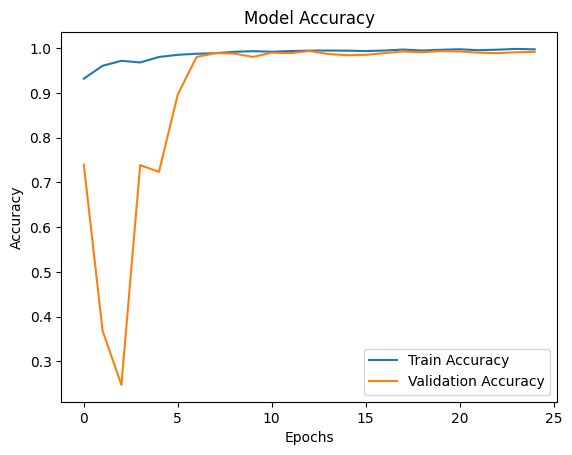

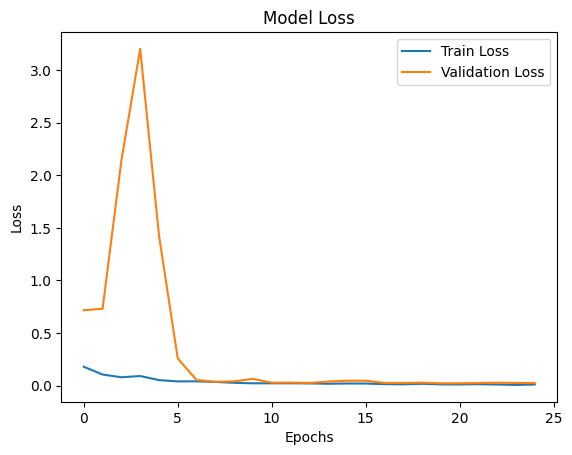

In [11]:

from tensorflow.keras.models import load_model
# Load the saved model
model = load_model('/kaggle/working/pneumonia_model.h5')


# Step 7: Visualize Training Performance
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 448ms/step


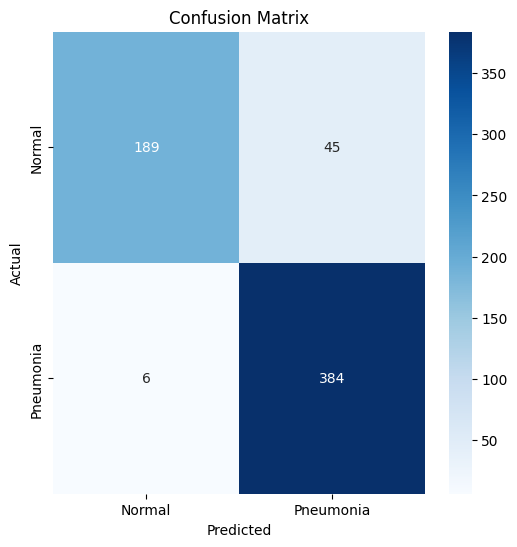

In [12]:
# Step 8: Evaluate the Model on Test Data
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [13]:
# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia']))


              precision    recall  f1-score   support

      Normal       0.97      0.81      0.88       234
   Pneumonia       0.90      0.98      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



****XAI

In [14]:
# Print the model summary to see all layers
# model.summary()

# Get the names of all layers
layer_names = [layer.name for layer in model.layers]

# Find the last convolutional layer
last_conv_layer_name = None
for name in reversed(layer_names):
    if 'conv' in name:  # Check if the layer name contains 'conv'
        last_conv_layer_name = name
        break

print(f"Last Convolutional Layer Name: {last_conv_layer_name}")


Last Convolutional Layer Name: top_conv


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Model output shape: (1, 1)
Conv outputs shape: (7, 7, 1280)
Pooled grads shape: (1280,)


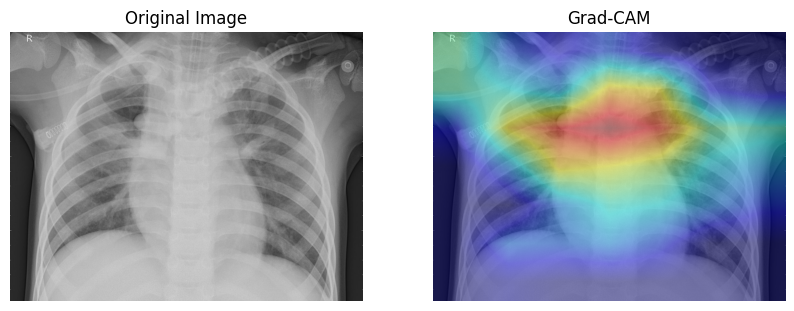

In [21]:
import numpy as np# Load your trained model
model = load_model('/kaggle/working/pneumonia_model.h5')

def generate_gradcam(model, image, layer_name, class_index):
    # Preprocess the image
    image = cv2.resize(image, (224, 224))  # Resize to match model input
    image = np.expand_dims(image, axis=0) / 255.0  # Normalize the image

    # Create a model for Grad-CAM
    grad_model = Model(inputs=model.input, outputs=[model.output, model.get_layer(layer_name).output])
    
    with tf.GradientTape() as tape:
        preds, conv_outputs = grad_model(image)
        loss = preds[0, class_index]  # Use the index for the target class

    # Compute gradients and create heatmap
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Check shapes before multiplication
    print(f"Conv outputs shape: {conv_outputs[0].shape}")
    print(f"Pooled grads shape: {pooled_grads.numpy().shape}")

    # Reshape pooled_grads if necessary
    if len(pooled_grads.shape) == 1:
        pooled_grads = tf.reshape(pooled_grads, (1, -1))  # Reshape to 2D

    # Multiply the feature map by the pooled gradients
    heatmap = tf.matmul(conv_outputs[0], pooled_grads, transpose_b=True)
    heatmap = tf.squeeze(heatmap)  # Remove single-dimensional entries
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize
    return heatmap

# Load a sample image
sample_image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person10_virus_35.jpeg'
sample_image = cv2.imread(sample_image_path)

# Check if the image is loaded correctly
if sample_image is None:
    print(f"Error loading image at: {sample_image_path}")
else:
    layer_name = 'top_conv'  # Last convolutional layer name

    # Preprocess the image for prediction
    resized_image = cv2.resize(sample_image, (224, 224))  # Resize image for model input
    preds = model.predict(np.expand_dims(resized_image, axis=0) / 255.0)
    print("Model output shape:", preds.shape)

    # Adjust class_index based on output shape
    class_index = 1 if preds.shape[1] > 1 else 0  # Example logic to determine index

    # Generate the Grad-CAM heatmap
    heatmap = generate_gradcam(model, sample_image, layer_name, class_index)

    # Resize and color the heatmap
    heatmap_resized = cv2.resize(heatmap, (sample_image.shape[1], sample_image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Blend the heatmap with the original image
    superimposed_img = cv2.addWeighted(sample_image, 0.6, heatmap_colored, 0.4, 0)
    superimposed_img = np.uint8(superimposed_img)

    # Display the original image and the Grad-CAM output
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Grad-CAM Image
    plt.subplot(1, 2, 2)
    plt.title('Grad-CAM')
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()


**LIME**

In [16]:
pip install --upgrade lime


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━

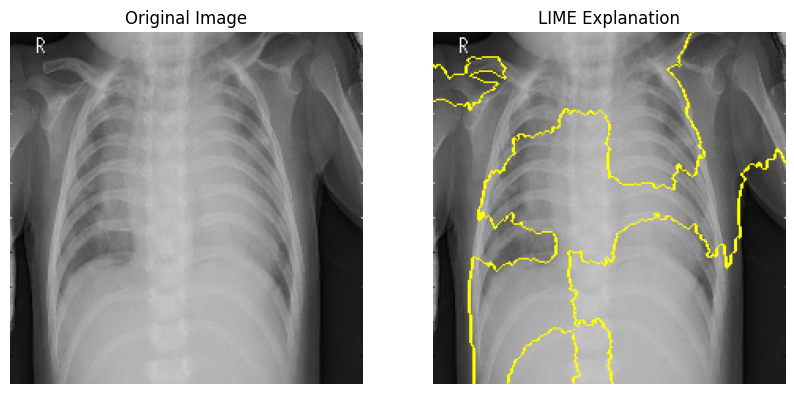

In [22]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from lime import lime_image
from tensorflow.keras.models import load_model
from skimage.segmentation import mark_boundaries

# Load your trained model
model = load_model('/kaggle/working/pneumonia_model.h5')

# Define the prediction function for LIME
def predict_fn(images):
    preds = model.predict(images)  # Ensure images are preprocessed correctly
    return preds

# Load and preprocess your sample image
sample_image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person112_bacteria_538.jpeg'
sample_image = cv2.imread(sample_image_path)

# Check if the image is loaded correctly
if sample_image is None:
    print(f"Error loading image at: {sample_image_path}")
else:
    # Resize and normalize the image
    sample_image = cv2.resize(sample_image, (224, 224)) / 255.0  # Normalize
    sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension

    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Generate explanation
    explanation = explainer.explain_instance(
        sample_image[0],  # Use the first image from the batch
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get the label and mask for the top predicted label
    top_label = explanation.top_labels[0]

    # Use the `explanation` object to get the image and mask
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # Display the original image and the LIME output
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(sample_image[0])  # Show normalized image without cv2.cvtColor
    plt.axis('off')

    # LIME Image
    plt.subplot(1, 2, 2)
    plt.title('LIME Explanation')
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')

    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

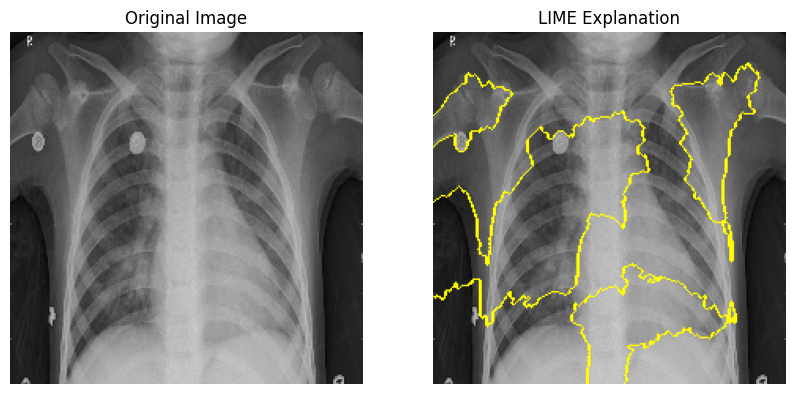

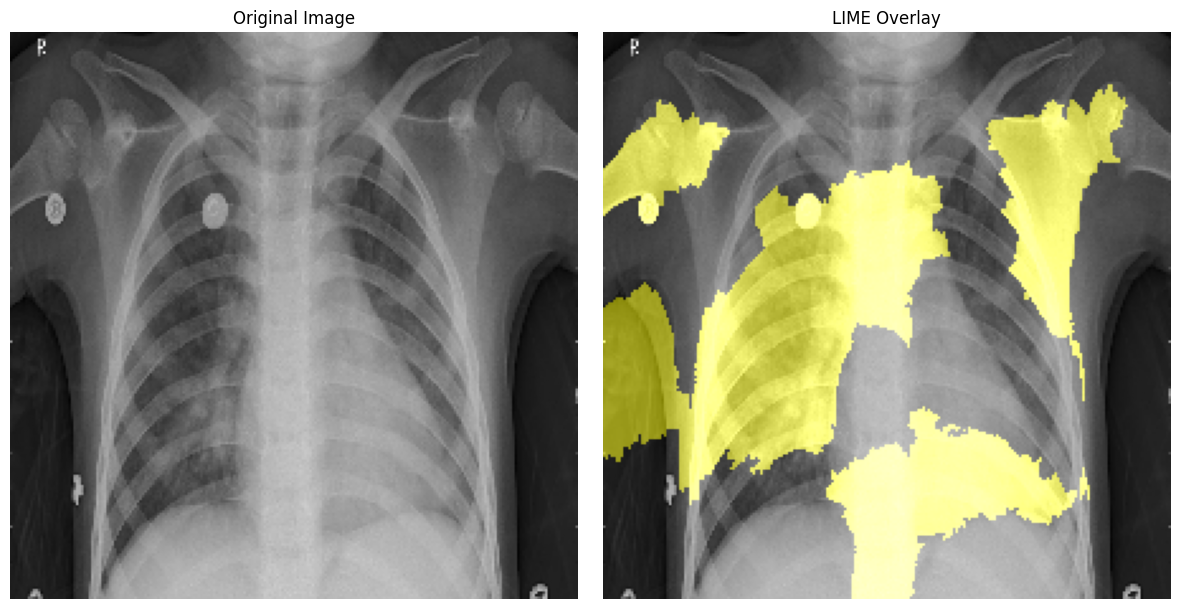

In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from lime import lime_image
from tensorflow.keras.models import load_model
from skimage.segmentation import mark_boundaries

# Load your trained model
model = load_model('/kaggle/working/pneumonia_model.h5')

# Define the prediction function for LIME
def predict_fn(images):
    preds = model.predict(images)  # Ensure images are preprocessed correctly
    return preds

# Load and preprocess your sample image
sample_image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person11_virus_38.jpeg'
sample_image = cv2.imread(sample_image_path)

# Check if the image is loaded correctly
if sample_image is None:
    print(f"Error loading image at: {sample_image_path}")
else:
    # Resize and normalize the image
    sample_image = cv2.resize(sample_image, (224, 224)) / 255.0  # Normalize
    sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension

    # Create a LIME explainer
    explainer = lime_image.LimeImageExplainer()

    # Generate explanation
    explanation = explainer.explain_instance(
        sample_image[0],  # Use the first image from the batch
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get the label and mask for the top predicted label
    top_label = explanation.top_labels[0]

    # Use the `explanation` object to get the image and mask
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    # Display the original image and the LIME output
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(sample_image[0])  # Show normalized image without cv2.cvtColor
    plt.axis('off')

    # LIME Image
    plt.subplot(1, 2, 2)
    plt.title('LIME Explanation')
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')

    plt.show()  # Show original and LIME images

    # Create LIME overlay
    overlay = np.zeros(sample_image[0].shape)  # Shape of the original image
    overlay[mask > 0] = [1, 1, 0]  # Yellow color for the explanation

    # Blend the original image with the overlay
    blended_image = np.clip(sample_image[0] + 0.5 * overlay, 0, 1)

    # Visualize the blended image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(sample_image[0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('LIME Overlay')
    plt.imshow(blended_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


**SHAP**

Found 624 images belonging to 2 classes.


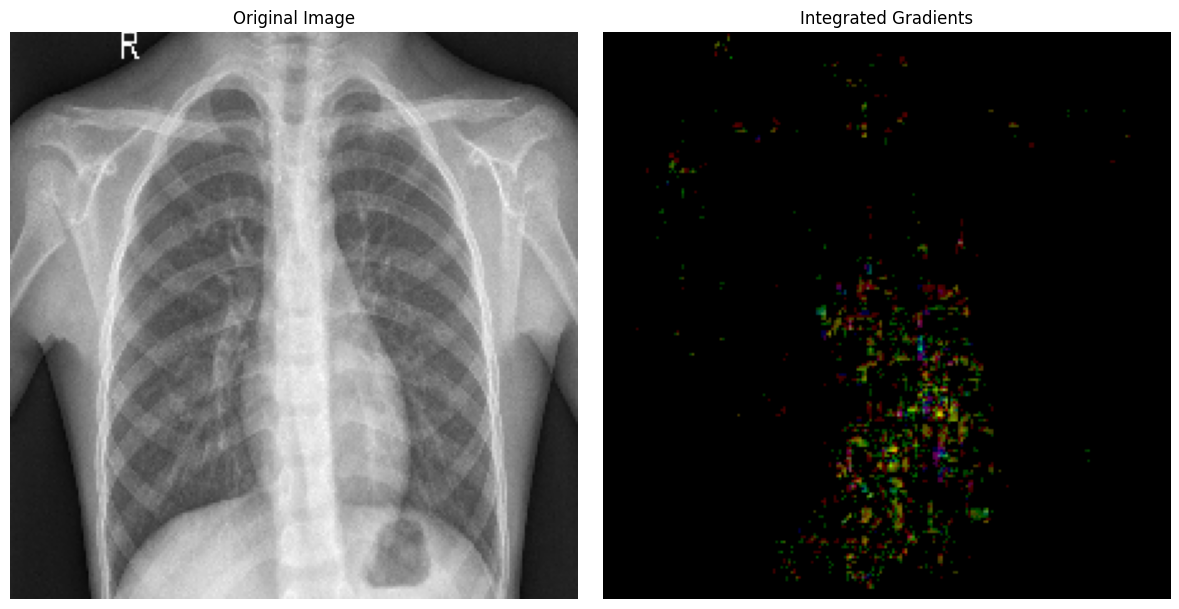

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load your trained model
model = load_model('/kaggle/working/pneumonia_model.h5')

# Load the test dataset
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Get a few samples from the test generator
sample_images, _ = next(test_generator)

# Function to compute integrated gradients
def integrated_gradients(model, input_image, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(input_image)
    
    input_image = tf.convert_to_tensor(input_image)
    baseline = tf.convert_to_tensor(baseline)
    
    # Create interpolated images
    scaled_inputs = [(baseline + (float(i) / steps) * (input_image - baseline)) for i in range(steps + 1)]
    
    # Calculate the gradients
    with tf.GradientTape() as tape:
        tape.watch(scaled_inputs)
        preds = model(tf.convert_to_tensor(scaled_inputs))
    
    grads = tape.gradient(preds, scaled_inputs)

    # Compute integrated gradients
    avg_grads = tf.reduce_mean(grads[:-1], axis=0)
    integrated_grads = (input_image - baseline) * avg_grads
    return integrated_grads.numpy()

# Compute integrated gradients for the first image
ig_values = integrated_gradients(model, sample_images[0])

# Normalize the integrated gradients for better visualization
ig_values_abs = np.abs(ig_values)
ig_values_abs /= np.max(ig_values_abs)  # Normalize to [0, 1]

# Apply a threshold to enhance important regions
threshold = 0.2  # You can adjust this threshold
ig_values_abs[ig_values_abs < threshold] = 0

# Visualize the integrated gradients
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(sample_images[0], cmap='gray')  # Display the first image
plt.axis('off')

# Integrated Gradients Image
plt.subplot(1, 2, 2)
plt.title('Integrated Gradients')
plt.imshow(ig_values_abs.reshape(224, 224, 3), cmap='plasma')  # Reshape and display
plt.axis('off')

plt.tight_layout()  # Adjust layout
plt.show()


